## A brief tutorial

Here's an example of some of the functionality in the [CausalityTools.jl](https://github.com/JuliaDynamics/CausalityTools.jl) package, which provides algorithms for characterizing dynamical coupling and causal interactions from time series data. The package is integrated in the [JuliaDynamics](https://github.com/JuliaDynamics) organization for dynamical systems, nonlinear dynamics and complex systems. The example was made in a [JupyterLab](https://jupyter.org) notebook using a [Julia](https://julialang.org) 1.6.0 kernel and [CausalityTools.jl](https://github.com/JuliaDynamics/CausalityTools.jl) version 1.2.0.

Please see the package [documentation](https://juliadynamics.github.io/CausalityTools.jl/stable/) for more details.

***

We first create a dedicated folder and start by activating a Julia project in that folder:

In [3]:
using Pkg
Pkg.activate("./")

Then we add the required packages to the project:

In [6]:
Pkg.add(["CausalityTools", "Plots", "LaTeXStrings"])

Now we are ready to precompile the packages we need for this example:

In [4]:
using CausalityTools, Plots, LaTeXStrings

### Generating time series from a dynamical system
CausalityTools.jl provides a range of different example systems as built-in functions. As an example, let's choose a discrete dynamical system composed of two coupled logistic maps where $x$ unidirectionally influences $y$, using the function ``logistic2_unidir``, which takes the following arguments:

 - $u_0$, a two-element vector specifying the initial states of $x$ and $y$
 - $c_{xy}$, a scalar controlling the strength of the influence of $x$ on $y$
 - $r_{1}$ and $r_{2}$ are the model parameters, which by default are set to values yielding chaotic behaviour
 - $\sigma$ is a scalar on $[0, 1]$ controlling the level of dynamical noise

For more details on this system, see [Example systems](https://juliadynamics.github.io/CausalityTools.jl/stable/example_systems/) in the documentation.

In [5]:
system = logistic2_unidir(u₀ = rand(2), 
                          c_xy = 0.5, 
                          r₁ = 3.78,
                          r₂ = 3.66,
                          σ = 0.05)

2-dimensional discrete dynamical system
 state:       [0.726652, 0.177727]
 rule f:      eom_logistic2_unidir
 in-place?    true
 jacobian:    ForwardDiff
 parameters:  [0.5, 3.78, 3.66, 0.05]

Now we can generate an orbit (a collection of points following the evolution function of the system) and extract time series for the $x$ and $y$ components:

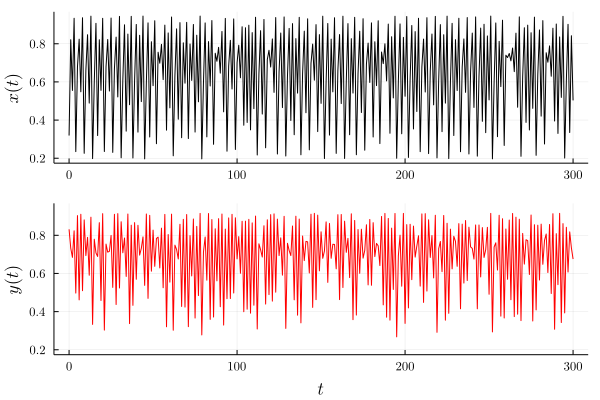

In [7]:
npts = 300 # number of points in the time series
Ttr = 1000 # how many transient points to skip

orbit = trajectory(system, npts, Ttr = Ttr) 
x = orbit[:, 1]
y = orbit[:, 2]

# set some nice plot font defaults
default(fontfamily="Computer Modern",
        yguidefontsize = 12,
        ytickfontsize = 8,
        xguidefontsize = 12,
        xtickfontsize = 8,
        legendfontsize = 12)


px = plot(0:npts, x, c = :black)
py = plot(0:npts, y, c = :red)

plot(px, py, layout = grid(2,1), link = :all, legend = false,
    xlabel =["" L"t"],  ylabel = [L"x(t)" L"y(t)"], size = (600, 400))

***

Now we can try to recover the unidirectional causal relationship $x \to y$ by computing causality statistics directly from the time series data. CausalityTools.jl provides a range of different methods, both distance-based and entropy-based. Here we will shamelessly plug an information-theoretic method proposed by [Haaga *et al.*](https://www.earthsystemevolution.com/publication/haaga_et_al_2020/), called [Predictive Asymmetry](https://juliadynamics.github.io/CausalityTools.jl/dev/predictive_asymmetry/). The particular implementation of predictive asymmetry used here is based on computing [Transfer Entropy](https://juliadynamics.github.io/CausalityTools.jl/stable/TransferEntropy/) across a range of temporal prediction lags. We choose a simple estimator that counts visitation frequency of states in a rectangular binning of the state space. For more background on these methods, including details on embedding parameters and different estimators, please see the [documentation](https://juliadynamics.github.io/CausalityTools.jl/stable/).

### Causal analysis

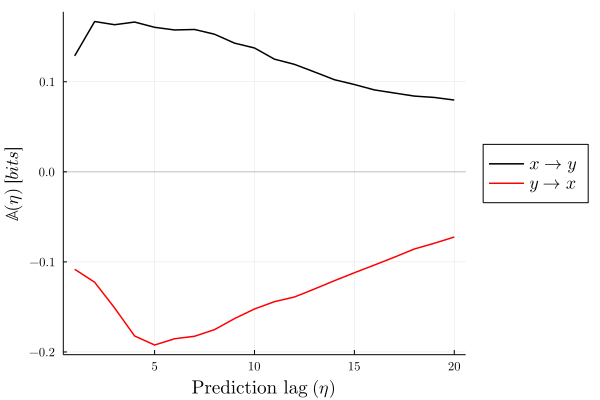

In [20]:
ηs = 1:20 # Prediction lags

# Specify an underlying estimator for transfer entropy
est = VisitationFrequency(RectangularBinning(4)) 

pa_xy = predictive_asymmetry(x, y, est, ηs) # from x to y
pa_yx = predictive_asymmetry(y, x, est, ηs) # from y to x


p_xy =  plot(ηs, pa_xy, label = L"x \to y", c = :black, lw = 1.5)
        plot!(ηs, pa_yx, label = L"y \to x", c = :red, lw = 1.5)
        hline!([0], lw = 1, α = 0.2, c = :black, label = "")

plot(p_xy, size = (600, 400), legend = :outerright, 
    xlabel = "Prediction lag "*L"(\eta)",  ylabel = L"\mathbb{A}(\eta)\ [bits]")

The predictive asymmetry results can be interpreted as follows: If two variables $a$ and $b$ are dynamically coupled in a *unidirectional* causal relationship $a \to b$, then we expect the predictive asymmetry from the driver variable $a$ to the response variable $b$ to be positive: $\mathbb{A}_{a \to b} > 0$. Conversely, we expect the predictive asymmetry from the response variable $b$ to the driver variable $a$ to be zero or negative:  $\mathbb{A}_{b \to a} \leq 0$. If there is a *bidirectional* coupling, then we expect both $\mathbb{A}_{a \to b}$ and $\mathbb{A}_{b \to a}$ to be positive (see example below). Furthermore, we expect the predictive asymmetry to converge towards zero with increasing prediction lag in a system-dependent manner, as the influence of the driver on the response variable diminishes.

In our example of two chaotic logistic maps unidirectionally coupled $x \to y$, we find that $\mathbb{A}_{x \to y} > 0$  and $\mathbb{A}_{y \to x} < 0$, which indicates a unidirectional causal relationships $x \to y$.

But what happens if the causal relationship goes both ways?

### Bidirectional causality

We can use the function ``logistic2_bidir`` to generate bidirectionally coupled logistic maps. The input arguments are the same as for the unidirectional system but there are two separate arguments for the coupling strengths and noise levels in each causal direction.

In [172]:
system2 = logistic2_bidir(u₀ = rand(2), 
                          c_xy = 0.3, 
                          c_yx = 0.3, 
                          r₁ = 3.7, 
                          r₂ = 3.8,
                          σ_xy = 0.05, 
                          σ_yx = 0.05)

2-dimensional discrete dynamical system
 state:       [0.248121, 0.343798]
 rule f:      eom_logistic2_bidir
 in-place?    true
 jacobian:    ForwardDiff
 parameters:  [0.3, 0.3, 3.7, 3.8, 0.05, 0.05]

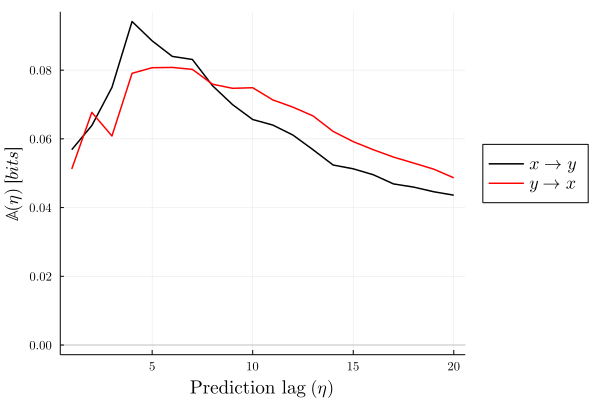

In [209]:
orbit = trajectory(system2, npts, Ttr = Ttr) 
x = orbit[:, 1]
y = orbit[:, 2]

pa_xy = predictive_asymmetry(x, y, est, ηs) # from x to y
pa_yx = predictive_asymmetry(y, x, est, ηs) # from y to x


p_xy =  plot(ηs, pa_xy, label = L"x \to y", c = :black, lw = 1.5)
        plot!(ηs, pa_yx, label = L"y \to x", c = :red, lw = 1.5)
        hline!([0], lw = 1, α = 0.2, c = :black, label = "")

plot(p_xy, size = (600, 400), legend = :outerright, 
    xlabel = "Prediction lag "*L"(\eta)",  ylabel = L"\mathbb{A}(\eta)\ [bits]")

In this case we find that both $\mathbb{A}_{x \to y}$  and $\mathbb{A}_{y \to x}$ are positive, indicating a two-way influence. We stress, however, that bidirectional interactions are notoriously difficult to characterize, and the results will vary considerably with different realizations of the system and with different parameters, especially for short time series. See [Haaga *et al.*](https://www.earthsystemevolution.com/publication/haaga_et_al_2020/) for a more comprehensive analysis of sensitivity and specificity for the logistic maps and many other systems.